#### GENERATING IMAGES, QUESTIONS AND ANSWERS

In [4]:
import numpy as np
from math import radians, cos
import cv2

class SortOfCLEVRGenerator(object):
    colors = [
        (0,0,255),      #red
        (255,0,0),      #blue
        (0,255,0),      #green
        (0,156,255),    #orange
        (0,255,255),    #yellow
        (128,128,128)   #grey
    ]
    shapes = [
        's',    #square
        'c',    #circle
    ]

    img_size = 75
    shape_size = 10

    question_vector_size = 11
    answer_vector_size = 10

    def __init__(self, number_questions=10, number_shapes=6):
        self.number_questions = number_questions
        self.number_shapes = number_shapes

    def generate_centers(self):
        centers = []
        for n in range(self.number_shapes):
            collision = True
            while collision:
                center = np.random.randint(self.shape_size, self.img_size - self.shape_size, 2)
                collision = False
                for c in centers:
                    if ((center-c)**2).sum() < (self.shape_size)**2:
                        collision = True
            centers.append(center)
        return centers

    def generate_sample(self):
        centers = self.generate_centers()
        shape_choice = np.random.randint(2, size=self.number_shapes)
        img = np.zeros((self.img_size,self.img_size,3))
        representation = []
        for idx, c in enumerate(centers):
            shape = self.shapes[shape_choice[idx]]
            if shape == 's':
                const = int(self.shape_size * cos(radians(45))/2)
                start = (c[0]-const, c[1]-const)
                end = (c[0]+const, c[1]+const)
                img = cv2.rectangle(img, start, end, self.colors[idx], -1)
            else:
                img = cv2.circle(img, (c[0], c[1]), int(self.shape_size/2), self.colors[idx], -1)
            representation.append([c, shape])
        return img, representation

    def generate_questions(self, representation, number_questions=10):
        # [red, blue, green, orange, yellow, gray, relational, non-relational, question 1, question 2, question 3]
        questions = []
        for q in range(number_questions):
            for r in range(2):
                question = [0] * self.question_vector_size
                color = np.random.randint(6)
                question[color] = 1
                question[6 + r] = 1
                question_type = np.random.randint(3)
                question[8 + question_type] = 1
                questions.append(question)
        return questions

    def generate_answers(self, representation, questions):
        #[yes, no, square, circle, 1, 2, 3, 4, 5, 6]
        answers = []
        for question in questions:
            answer = [0] * self.answer_vector_size
            color = question[:6].index(1)
            if question[6]:
                if question[8]: #The shape of the nearest object?
                    dist = [((representation[color][0]-obj[0])**2).sum() for obj in representation]
                    dist[dist.index(0)] = float('inf')
                    closest = dist.index(min(dist))
                    if representation[closest][1] == 's':
                        answer[2] = 1
                    else:
                        answer[3] = 1
                elif question[9]: #The shape of the farthest object?
                    dist = [((representation[color][0]-obj[0])**2).sum() for obj in representation]
                    furthest = dist.index(max(dist))
                    if representation[furthest][1] == 's':
                        answer[2] = 1
                    else:
                        answer[3] = 1

                else: #How many objects have the same shape?
                    count = -1
                    shape = representation[color][1]
                    for obj in representation:
                        if obj[1] == shape:
                            count += 1
                    answer[count + 4] = 1
            else:
                if question[8]: #Is it a circle or a rectangle?
                    if representation[color][1] == 's':
                        answer[2] = 1
                    else:
                        answer[3] = 1
                elif question[9]: #Is it on the bottom of the image?
                    if representation[color][0][1] > self.img_size/2:
                        answer[0] = 1
                    else:
                        answer[1] = 1
                else: #Is it on the left of the image?
                    if representation[color][0][0] > self.img_size/2:
                        answer[1] = 1
                    else:
                        answer[0] = 1
            answers.append(answer)
        return answers

    def generate_dataset(self):
        img, representation = self.generate_sample()
        questions = self.generate_questions(representation)
        answers = self.generate_answers(representation, questions)
        dataset = (img.astype('float32'), questions, answers)
        return dataset


In [2]:
import time
from tqdm import *
import pickle

In [5]:
test_dataset = []
train_dataset = []
test_size = 200 #200
train_size = 9800 #9800


generator = SortOfCLEVRGenerator()

for i in tqdm(range(train_size), desc='Generating Sort-of-CLEVR Training Dataset'):
        dataset = generator.generate_dataset()
        train_dataset.append(dataset)

for i in tqdm(range(test_size), desc='Generating Sort-of-CLEVR Test Dataset'):
        dataset = generator.generate_dataset()
        test_dataset.append(dataset)
        
with open("sort-of-clevr.p", 'wb') as f:
    pickle.dump((train_dataset, test_dataset), f, protocol=2)

Generating Sort-of-CLEVR Test Dataset: 100%|██████████| 200/200 [00:00<00:00, 1195.05it/s]


In [6]:
import numpy as np
train_img = []
train_q = []
train_a = []
for img, questions, answers in test_dataset:
    img_train = img/255
    for q, a in zip(questions, answers):
        train_img += [img_train]
        train_q += [q]
        train_a += [a]
train_img = np.stack(train_img)
train_q = np.vstack(train_q)
train_a = np.vstack(train_a)

In [7]:
print(len(train_img))
print(len(train_a))

4000
4000


In [8]:
img, questions, answers = generator.generate_dataset()

### Function to translate Question and Answer into string

In [9]:
import matplotlib.pyplot as plt

def visualize_img(img):
    img = np.fliplr(img.reshape(-1,3)).reshape(img.shape)
    plt.imshow(img)
    plt.show()

def translate_question(q):
    if len(q) != 11:
        return 'Not a proper question'
    colors = ['red', 'blue', 'green', 'orange', 'yellow', 'gray']
    idx= np.argwhere(q[:6])[0][0]
    color = colors[idx]
    if q[6]:
        if q[8]:
            return 'The shape of the nearest object to the object in ' + color + ' is?' 
        elif q[9]:
            return 'The shape of the farthest object away from the object in ' + color + ' is?'
        elif q[10]:
            return 'How many objects have the same shape as the object in ' + color + '?'
    else:
        if q[8]:
            return 'Is the object in color ' + color + ' a circle or a rectangle?'
        elif q[9]:
            return 'Is the object in color ' + color + ' on the bottom of the image?'
        elif q[10]:
            return 'Is the object in color ' + color + ' on the left of the image?'
        
def translate_answer(a):
    if len(a) != 10:
        return 'Not a proper answer'
    if a[0]:
        return 'yes'
    if a[1]:
        return 'no'
    if a[2]:
        return 'rectangle'
    if a[3]:
        return 'circle'
    return np.argwhere(a[4:])[0][0] + 1

### Example

10


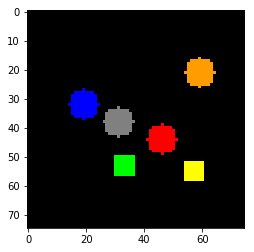

(75, 75, 3)
Is the object in color red on the bottom of the image?
yes


In [11]:
import numpy as np
idx = 20
idb = 7
img, q, a = train_dataset[idx]
print(len(train_dataset[idx][2][1]))
visualize_img(img/255)
print (img.shape)
print (translate_question(q[idb]))
print (translate_answer(a[idb]))

### CNN Feature Maps Post-process to Relation Network Objects

In [18]:
import keras
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization
def ConvolutionNetworks(kernel_size=3, stride_size=2):
    def conv(model):
        model = Conv2D(24, (5, 5), strides=(stride_size, stride_size),activation='relu',input_shape=(75, 75, 3), data_format='channels_last')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (5, 5), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (kernel_size, kernel_size), strides=(stride_size, stride_size),activation='relu')(model)
        model = BatchNormalization()(model)
        model = Conv2D(24, (3, 3), strides=(1, 1),activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

In [19]:
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Concatenate, Add
from keras.layers.normalization import BatchNormalization

### Function for  different layers (Eg. MLP , G_THETA).

In [36]:
from keras.utils import plot_model

def g_th(layers):
    def f(model):
        for n in range(len(layers)):
            model = layers[n](model)
        return model
    return f

def stack_layer(layers):
    def f(x):
        for k in range(len(layers)):
            x = layers[k](x)
        return x
    return f

def g_theta(h_unit=256, layers=4):
    r = []
    for k in range(layers):
        r.append(Dense(h_unit))
        r.append(Activation('relu'))
    return g_th(r)

def get_MLP():
    return g_th()

def RelationNetworks(objects, question):
    g_t = g_theta()
    relations = compute_relations(objects,question)
    g_all = []
    for i, r in enumerate(relations):
        g_all.append(g_t(r))
    combined_relation = Add()(g_all)
    f_out = f_theta()(combined_relation)
    return f_out

def build_tag(conv):
    d = K.int_shape(conv)[2]
    tag = np.zeros((d,d,2))
    for i in range(d):
        for j in range(d):
            tag[i,j,0] = float(int(i%d))/(d-1)*2-1
            tag[i,j,1] = float(int(j%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag, axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag, [batch_size,1,1,1])
    return Input(tensor=tag)

### Definning Visual Model

In [37]:
visual_scene = Input((75, 75, 3))
visual_question = Input((11,))
visual_conv = ConvolutionNetworks()(visual_scene)
tag = build_tag(visual_conv)
visual_conv = Concatenate()([tag, visual_conv])
visual_RN = RelationNetworks(visual_conv, visual_question)
visual_out = Dense(10, activation='softmax')(visual_RN)
VisualModel = Model(inputs=[visual_scene, visual_question, tag], outputs=visual_out)

In [38]:
print(VisualModel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 36, 36, 24)   1824        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 36, 36, 24)   96          conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 24)   14424       batch_normalization_17[0][0]     
__________________________________________________________________________________________________
batch_norm

                                                                 input_17[0][0]                   
                                                                 lambda_15[17][0]                 
                                                                 lambda_15[19][0]                 
                                                                 input_17[0][0]                   
                                                                 lambda_15[17][0]                 
                                                                 lambda_15[20][0]                 
                                                                 input_17[0][0]                   
                                                                 lambda_15[17][0]                 
                                                                 lambda_15[21][0]                 
                                                                 input_17[0][0]                   
          

                                                                 dense_33[478][0]                 
                                                                 dense_33[479][0]                 
                                                                 dense_33[480][0]                 
                                                                 dense_33[481][0]                 
                                                                 dense_33[482][0]                 
                                                                 dense_33[483][0]                 
                                                                 dense_33[484][0]                 
                                                                 dense_33[485][0]                 
                                                                 dense_33[486][0]                 
                                                                 dense_33[487][0]                 
          

                                                                 activation_30[217][0]            
                                                                 activation_30[218][0]            
                                                                 activation_30[219][0]            
                                                                 activation_30[220][0]            
                                                                 activation_30[221][0]            
                                                                 activation_30[222][0]            
                                                                 activation_30[223][0]            
                                                                 activation_30[224][0]            
                                                                 activation_30[225][0]            
                                                                 activation_30[226][0]            
          

                                                                 activation_32[594][0]            
                                                                 activation_32[595][0]            
                                                                 activation_32[596][0]            
                                                                 activation_32[597][0]            
                                                                 activation_32[598][0]            
                                                                 activation_32[599][0]            
                                                                 activation_32[600][0]            
                                                                 activation_32[601][0]            
                                                                 activation_32[602][0]            
                                                                 activation_32[603][0]            
          

### Data Generator for training and testing

In [40]:
import numpy as np

class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, training_set, test_set, is_baseline, dim_x = 75, dim_y = 75, channel = 3, q_dim = 11, a_dim = 10, batch_size = 64, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.channel = channel
        self.q_dim = q_dim
        self.a_dim = a_dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.training_set = training_set
        self.test_set = test_set
        self.is_baseline = is_baseline

    def generate_training(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            
            if self.shuffle:
                np.random.shuffle(self.training_set)

            # Generate batches
            data_size = len(self.training_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.training_set[i: i + self.batch_size])
                imgs, questions, answers = self.randomize(imgs, questions, answers)
                yield [imgs, questions], answers
                
    def generate_test(self):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            if self.shuffle:
                np.random.shuffle(self.test_set)

            # Generate batches
            data_size = len(self.test_set)
            imax = int(data_size/self.batch_size)
            for i in range(imax):
                # Generate data
                imgs, questions, answers = self.__data_generation(self.test_set[i: i+self.batch_size])
                imgs, questions, answers = self.randomize(imgs, questions, answers)
                yield [imgs, questions], answers
    
    def randomize(self, a, b, c):
        # Generate the permutation index array.
        permutation = np.random.permutation(a.shape[0])
        # Shuffle the arrays by giving the permutation in the square brackets.
        shuffled_a = a[permutation]
        shuffled_b = b[permutation]
        shuffled_c = c[permutation]
        return shuffled_a, shuffled_b, shuffled_c

    def __data_generation(self, dataset):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        q_lenght = len(dataset[0][1])
        imgs = np.empty((self.batch_size*q_lenght, self.dim_x, self.dim_y, self.channel))
        questions = np.empty((self.batch_size*q_lenght, self.q_dim), dtype = int)
        answers = np.empty((self.batch_size*q_lenght, self.a_dim), dtype = int)
        c = 0
        for img, question, answer in dataset:
            img = img/255
            for q, a in zip(question, answer):
                imgs[c, :, :, :]  = img
                questions[c, :] = q
                answers[c, :] = a
                c += 1
        return imgs, questions, answers

In [41]:
from keras.optimizers import Adam
lr = 1e-4
adam = Adam(lr=lr)
VisualModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Training Model

In [ ]:
batch_size = 1
data_generator = DataGenerator(train_dataset, test_dataset, False, batch_size=batch_size)
training_generator = data_generator.generate_training()
validation_generator = data_generator.generate_test()
visualmodel_history = VisualModel.fit_generator(generator = training_generator,
                    steps_per_epoch = (len(train_dataset))//batch_size,
                    validation_data = validation_generator,
                    validation_steps = (len(test_dataset))//batch_size,
                    epochs = 5)

In [45]:
from keras import models
VisualModel.load_weights('Model/VisualModelLarge5.h5')

### Creating Test Dataset

In [46]:
def create_test_set(dataset_size):
    generator = SortOfCLEVRGenerator()
    testset = []
    rel_testset = []
    norel_testset = []
    norel_ids = []
    rel_ids = []

    for i in range(dataset_size):
        imgs, questions, answers = generator.generate_dataset()
        testset.append((imgs, questions, answers))
        norel_questions = []
        rel_questions = []
        norel_answers = []
        rel_answers = []
        for q_idx in range(len(questions)):
            if questions[q_idx][6] == 1:
                rel_questions.append(questions[q_idx])
                rel_answers.append(answers[q_idx]) 
            else:
                norel_questions.append(questions[q_idx])
                norel_answers.append(answers[q_idx]) 
        norel_testset.append((imgs, norel_questions, norel_answers))
        rel_testset.append((imgs, rel_questions, rel_answers))
    return rel_testset, norel_testset, testset

In [47]:
def test_model(model):
    rel, norel, test = create_test_set(200)
    batch_size = 1
    rel_generator = DataGenerator(None, rel, False, batch_size=batch_size)
    norel_generator = DataGenerator(None, norel, False, batch_size=batch_size)
    test_generator = DataGenerator(None, test, False, batch_size=batch_size)
    r_generator = rel_generator.generate_test()
    res_rel = model.evaluate_generator(r_generator, steps=len(rel)//batch_size, max_queue_size=10, workers=1, use_multiprocessing=False)
    nr_generator = norel_generator.generate_test()
    res_norel = model.evaluate_generator(nr_generator, steps=len(rel)//batch_size, max_queue_size=10, workers=1, use_multiprocessing=False)
    re_generator = test_generator.generate_test()
    res = model.evaluate_generator(re_generator, steps=len(rel)//batch_size, max_queue_size=10, workers=1, use_multiprocessing=False)
    print(res_rel)
    print(res_norel)
    print(res)
    return res_rel[1], res_norel[1], res[1]

In [32]:
res = test_model(VisualModel)

[0.5895933140032412, 0.8399999974668027]
[0.12473873559606993, 0.969999997317791]
[0.35716602137341397, 0.9049999949336052]


In [114]:
print ('The accracy of Relational Question is %f, The accuracy of Non-Relational Question is %f, Overall Accuracy is %f' %res)

The accracy of Relational Question is 0.837000, The accuracy of Non-Relational Question is 0.968000, Overall Accuracy is 0.902500


In [115]:
print(VisualModel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 36, 36, 24)   1824        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 36, 36, 24)   96          conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 24)   14424       batch_normalization_9[0][0]      
__________________________________________________________________________________________________
batch_norm

dense_15 (Dense)                (None, 256)          16384       concatenate_5[0][0]              
                                                                 concatenate_5[1][0]              
                                                                 concatenate_5[2][0]              
                                                                 concatenate_5[3][0]              
                                                                 concatenate_5[4][0]              
                                                                 concatenate_5[5][0]              
                                                                 concatenate_5[6][0]              
                                                                 concatenate_5[7][0]              
                                                                 concatenate_5[8][0]              
                                                                 concatenate_5[9][0]              
          

activation_14 (Activation)      (None, 256)          0           dense_16[0][0]                   
                                                                 dense_16[1][0]                   
                                                                 dense_16[2][0]                   
                                                                 dense_16[3][0]                   
                                                                 dense_16[4][0]                   
                                                                 dense_16[5][0]                   
                                                                 dense_16[6][0]                   
                                                                 dense_16[7][0]                   
                                                                 dense_16[8][0]                   
                                                                 dense_16[9][0]                   
          

                                                                 dense_18[154][0]                 
                                                                 dense_18[155][0]                 
                                                                 dense_18[156][0]                 
                                                                 dense_18[157][0]                 
                                                                 dense_18[158][0]                 
                                                                 dense_18[159][0]                 
                                                                 dense_18[160][0]                 
                                                                 dense_18[161][0]                 
                                                                 dense_18[162][0]                 
                                                                 dense_18[163][0]                 
          

In [116]:
print(len(test_dataset))

200


In [53]:
def one_hot(a, num_classes): 
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

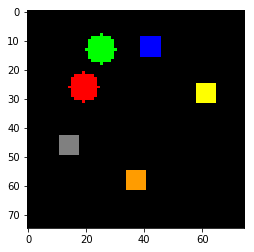

[[0 0 0 0 1 0 1 0 0 1 0]]
Question:  The shape of the farthest object away from the object in yellow is?
Predicted answer: rectangle
Actual answer: rectangle


In [34]:
#### Test image
idx = 25
idb = 16
img, q, a = test_dataset[idx]
img1 = img/255
visualize_img(img1)
act_ans = translate_answer(a[idb])
#print(a[idb])

ques = translate_question(q[idb])
test_img = np.reshape(img1,(1,75,75,3))
test_q = np.reshape(q[idb],(1,11))
# print(test_q)
#t = np.array([img,np.array(q[4])])
### predict answer

print(test_q)

data1 = []
data1.append(test_img)
data1.append(test_q)
test_a = VisualModel.predict(data1)
# print(test_q)
#print(test_a[0])
test_ans=one_hot(np.array(np.argmax(test_a[0])),10)
test_ans = translate_answer(test_ans)

print("Question: ",ques)
print("Predicted answer:",test_ans)
print("Actual answer:",act_ans)

### Visualizing questions and testing for random question

In [49]:
for ques in test_dataset[1][1]:
    print(ques)
    print(translate_question(ques))

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]
The shape of the nearest object to the object in yellow is?
[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Is the object in color yellow on the bottom of the image?
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]
The shape of the farthest object away from the object in yellow is?
[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Is the object in color orange on the bottom of the image?
[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
The shape of the farthest object away from the object in orange is?
[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Is the object in color orange a circle or a rectangle?
[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
How many objects have the same shape as the object in gray?
[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0]
Is the object in color orange on the bottom of the image?
[0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]
The shape of the nearest object to the object in green is?
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Is the object in color gray on the bottom of the image?
[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
The shape of the farthest 

In [50]:
q = [0,0,0,1,0,0,1,0,0,1,0]

In [51]:
im,_,_ = test_dataset[1]
im = im/255
test_img = np.reshape(im,(1,75,75,3))
test_q = np.reshape(q,(1,11))

In [54]:
test_a = VisualModel.predict([test_img,test_q])
test_ans=one_hot(np.array(np.argmax(test_a[0])),10)
test_ans = translate_answer(test_ans)

In [55]:
print(test_ans)

rectangle
